In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import dill
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from rich import print
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split


from aifeel.model.nn import NNClassifier
from aifeel.util import gen_dataframe, read_corpus
from aifeel.util.feature_extraction import extract_features, feature_to_vector
from aifeel.util.preprocess import preprocess_text

In [3]:
negative_corpus, positive_corpus = read_corpus("negative-reviews"), read_corpus(
    "positive-reviews"
)
negative_words, positive_words = set(read_corpus("negative-words")), set(
    read_corpus("positive-words")
)

In [4]:

df = gen_dataframe(positive_corpus, negative_corpus, random_state=42)
df["clean_review"] = df["review"].apply(preprocess_text)


In [5]:
base_feature_count = 1000
extra_feature_count = 2
feature_count = base_feature_count - (6 + extra_feature_count) # 6 primary features + 2 extra features
cv = CountVectorizer(max_features=feature_count)  # 6 primary features + 2 extra features
cv.fit(df["clean_review"])

CountVectorizer(max_features=992)

In [6]:


def vectorizer(review):
    result = cv.transform([review])
    return result.toarray()[0].tolist() # type: ignore
    #        ^      ^          ^
    #   spmatrix ndarray    list
    # it definitely exists, type hinter is just bad


In [7]:


df["features"] = df["clean_review"].apply(
    extract_features, args=(positive_words, negative_words), vectorizer=vectorizer
)
df["feature_vector"] = df["features"].apply(feature_to_vector, vectorizer=True)

In [8]:
X = np.array(df["feature_vector"].tolist())
y = np.array(df["tag"].tolist(), dtype=np.int32)

In [9]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [10]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(32000, 1000)

(8000, 1000)

(32000,)

(8000,)

In [11]:
model = NNClassifier(epochs=10, batch_size=32, lr=0.0001)

In [12]:
model.fit(X_train, y_train)


Epoch 1/10


900/900 [==============================] - 12s 8ms/step - loss: 0.3315 - accuracy: 0.8618 - val_loss: 0.2089 - val_accuracy: 0.9137
Epoch 2/10
900/900 [==============================] - 6s 6ms/step - loss: 0.2028 - accuracy: 0.9197 - val_loss: 0.1841 - val_accuracy: 0.9297
Epoch 3/10
900/900 [==============================] - 6s 7ms/step - loss: 0.1779 - accuracy: 0.9307 - val_loss: 0.1725 - val_accuracy: 0.9344
Epoch 4/10
900/900 [==============================] - 6s 7ms/step - loss: 0.1612 - accuracy: 0.9380 - val_loss: 0.1709 - val_accuracy: 0.9344
Epoch 5/10
900/900 [==============================] - 6s 7ms/step - loss: 0.1507 - accuracy: 0.9416 - val_loss: 0.1662 - val_accuracy: 0.9366
Epoch 6/10
900/900 [==============================] - 7s 8ms/step - loss: 0.1409 - accuracy: 0.9461 - val_loss: 0.1663 - val_accuracy: 0.9384
Epoch 7/10
900/900 [==============================] - 7s 8ms/step - loss: 0.1330 - accuracy: 0.9492 - val_loss: 0.1644 - val_accuracy: 0.9372
Ep

NNClassifier(lr=0.0001)

In [13]:
y_pred = model.predict(X_test)

250/250 [==============================] - 1s 3ms/step


In [14]:

print(classification_report(y_test, y_pred))

precision    recall  f1-score   support

           0       0.93      0.94      0.94      4000
           1       0.94      0.93      0.93      4000

    accuracy                           0.94      8000
   macro avg       0.94      0.94      0.94      8000
weighted avg       0.94      0.94      0.94      8000

In [15]:
print(model.score(X_test, y_test))

250/250 [==============================] - 1s 4ms/step


0.935375

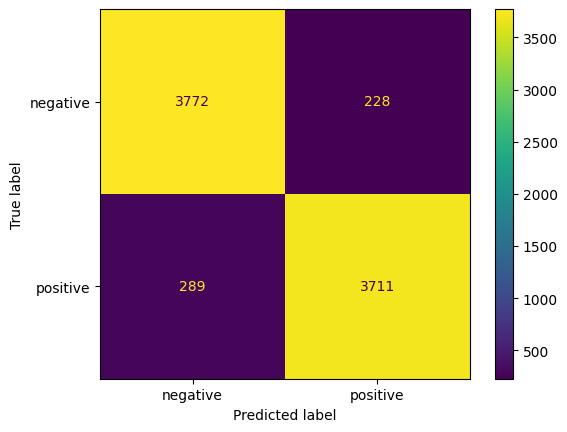

In [16]:

conf_mat = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(conf_mat, display_labels=["negative", "positive"])

disp.plot()
plt.show()

In [22]:
test_reviews = [
    "I hate this movie",
    "Not bad",
    "No bad",
    "I like this movie",
    "damn this movie so good, i want all the actors in this movie to fucking jump off a cliff, refund my time lil bro",
    "skill issue",
]

test_reviews = [preprocess_text(review) for review in test_reviews]
test_reviews = [extract_features(review, positive_words, negative_words, vectorizer=vectorizer) for review in test_reviews]
test_reviews = np.array([feature_to_vector(review, vectorizer=True) for review in test_reviews])

print(model.predict(test_reviews))

1/1 [==============================] - 0s 468ms/step


[[0.592055   0.40794498]
 [0.9680641  0.03193589]
 [0.919714   0.08028603]
 [0.22391349 0.7760865 ]
 [0.05309176 0.94690824]
 [0.96859133 0.03140864]]

In [18]:
import os
from pathlib import Path

export_base = Path("export/model/NNClassifier")


if not os.path.exists(export_base):
    export_base.mkdir(parents=True, exist_ok=True)

In [19]:
model.save(export_base / "model.dill")

In [20]:
with open(export_base / "vectorizer.dill", "wb") as f:
    dill.dump(cv, f)

In [21]:
with open(export_base / "data.npz", "wb") as f:
    np.savez_compressed(
        f,
        X_train=X_train,
        X_test=X_test,
        y_train=y_train,
        y_test=y_test
    )